## Python demonstration for VCCA2024

Simulate hearing loss on an audio signal and visualise the neural representation of sound (neural activity) in the brain using a deep neural network (DNN) auditory model. 

Fotios Drakopoulos, UCL, June 2024

In [1]:
# Define whether to use a GPU for executing the model
# CPU is used by default (empty string)
GPU = "" # set to a number to use a specific GPU (if available)
# Set the CPU/GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress warnings

## Import packages/dependencies

In [2]:
# Required packages
import csv
import json
import logging
from pathlib import Path
import numpy as np
from numpy import ndarray
from omegaconf import DictConfig, OmegaConf
import sys
# Clarity Challenge repository for running the MSBG model
sys.path.append('clarity')
from clarity.evaluator.mbstoi.mbstoi import mbstoi
from clarity.evaluator.mbstoi.mbstoi_utils import find_delay_impulse
from clarity.evaluator.msbg.msbg import Ear
from clarity.evaluator.msbg.msbg_utils import MSBG_FS, pad
from clarity.utils.audiogram import Listener, Audiogram
from clarity.utils.file_io import read_signal, write_signal
# ICNet repository for running the ICNet model
sys.path.append('ICNet/src')
from ICNet_functions import *
# Extra packages to import
import yaml
from time import time
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import IPython

In [3]:
# Function from clarity.recipes.cec1.baseline.evaluate to simulate hearing loss
def listen(ear, signal: ndarray, listener: Listener):
    """
    Generate MSBG processed signal
    :param ear: MSBG ear
    :param wav: binaural signal
    :return: binaural signal
    """
    ear.set_audiogram(listener.audiogram_left)
    out_l = ear.process(signal[:, 0])

    ear.set_audiogram(listener.audiogram_right)
    out_r = ear.process(signal[:, 1])

    if len(out_l[0]) != len(out_r[0]):
        diff = len(out_l[0]) - len(out_r[0])
        if diff > 0:
            out_r[0] = np.flipud(pad(np.flipud(out_r[0]), len(out_l[0])))
        else:
            out_l[0] = np.flipud(pad(np.flipud(out_l[0]), len(out_r[0])))
    return np.concatenate([out_l, out_r]).T

## Hearing loss simulation

In [4]:
# Defines the path of a sound file to use as input
wavfile_path = 'ICNet/scribe_male_talker.wav'
# Sound intensity in dB SPL - used to calibrate the sound input
sound_level = 70
p0 = 2e-5 # dB SPL reference of 2e-5 Pascal is used
fs_audio = 44100 # MSBG sampling frequency

In [5]:
# Read the wavfile and resample to the model sampling frequency
audio_input, _ = wavfile_read(wavfile_path,fs_audio)
# Calibrate to the desired sound level
audio_input = p0 * 10**(sound_level/20) * audio_input / rms(audio_input)

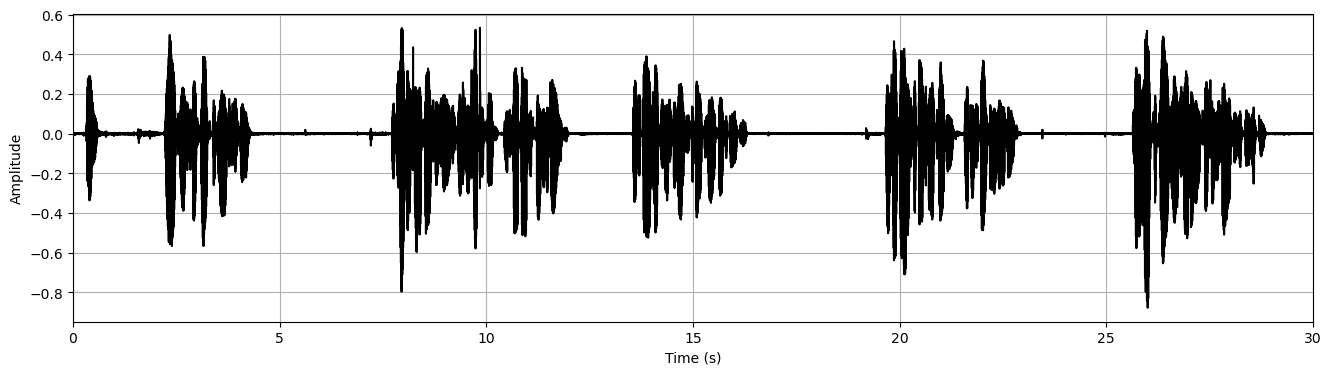

In [6]:
# Plot the whole audio signal
t_audio = np.arange(0., audio_input.size/fs_audio, 1./fs_audio)

f = plt.figure(figsize=(16,4))
plt.plot(t_audio,audio_input,'k');
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0,30)
plt.grid();

In [7]:
IPython.display.Audio("ICNet/scribe_male_talker.wav")

In [8]:
# Keep only a segment of the signal (between 7.5 to 12.5 s)
audio_input = audio_input[int(7.5*fs_audio):int(12.5*fs_audio)]

In [9]:
# Define a hearing-loss audiogram to simulate loss of audibility
freqs = [250, 500, 1000, 2000, 3000, 4000, 6000, 8000] # default centre frequencies for the MSBG model
dB_HL = [0, 0, 15, 35, 40, 50, 58, 60] # example hearing loss for each frequency
# NH reference (no hearing loss)
dB_NH = [0, 0, 0, 0, 0, 0, 0, 0]

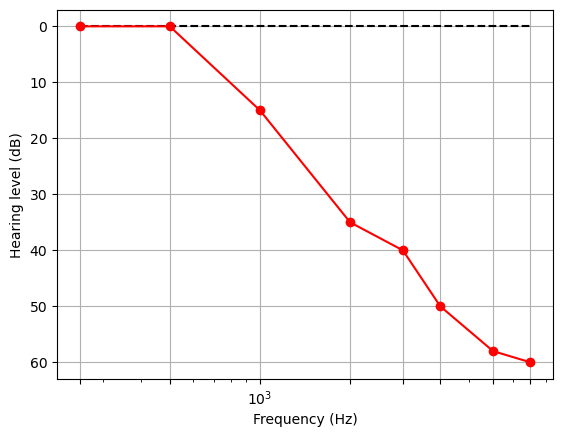

In [10]:
# Plot the generated audiogram
plt.semilogx(freqs,dB_NH,'k--')
plt.semilogx(freqs,dB_HL,'-ro')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hearing level (dB)')
plt.gca().invert_yaxis()
plt.xticks(freqs)
plt.grid();

In [11]:
## Simulate hearing loss using the MSBG model provided by the Clarity Challenge
## Code adapted from the example evaluation script from CEC1: https://github.com/claritychallenge/clarity/blob/main/recipes/cec1/baseline/evaluate.py
# define the audiograms in Clarity format
audiogram_nh = Audiogram(levels=dB_NH,frequencies=freqs)
audiogram_hl = Audiogram(levels=dB_HL,frequencies=freqs)
# Initialize the MSBG parameters
cfg = OmegaConf.load('clarity/recipes/cec1/baseline/config.yaml')
cfg.MSBGEar.sample_rate = fs_audio
cfg.MSBGEar.equiv_0db_spl = float(-20*np.log10(p0))
cfg.MSBGEar.ahr = 20
ear = Ear(**cfg.MSBGEar)
# Make a reference listener with the NH audiogram
listener_nh = Listener(audiogram_nh, audiogram_nh)
# Make a hearing-impaired listener with the HL audiogram
listener_hl = Listener(audiogram_hl, audiogram_hl)
# Make a two channel sound input by repeating the monaural signal
audio_input_2ch = np.array([audio_input,audio_input]).T
# Get the two audio outputs
audio_output_nh = listen(ear, audio_input_2ch, listener_nh)
audio_output_hl = listen(ear, audio_input_2ch, listener_hl)
# Keep only the first channel and match sizes
audio_output_nh = audio_output_nh[:,0]
audio_output_hl = audio_output_hl[:audio_output_nh.size,0]
# Make the time array for audio
t_audio = np.arange(0., audio_output_nh.size/fs_audio, 1./fs_audio)

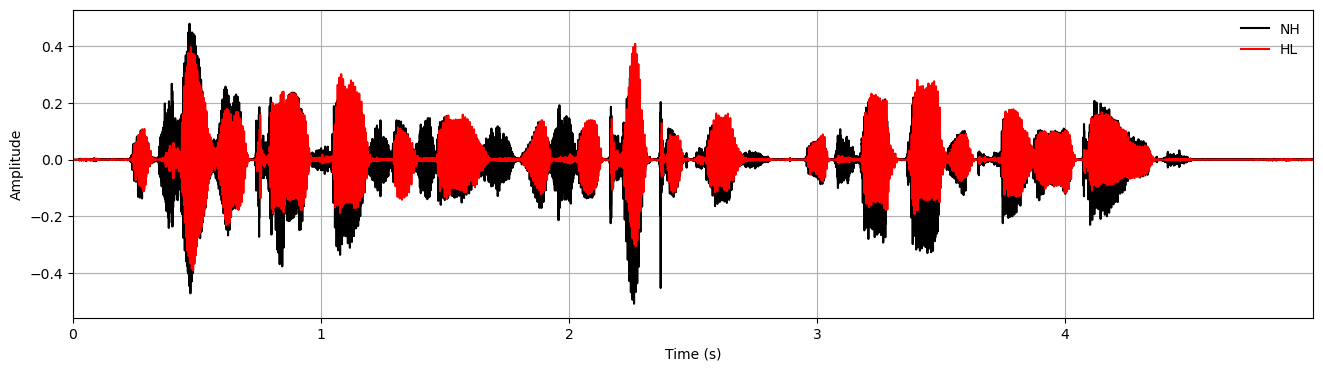

In [12]:
# Plot the audio outputs for the NH and the HL listeners across time
f = plt.figure(figsize=(16,4))
plt.plot(t_audio,audio_output_nh,'k',label='NH');
plt.plot(t_audio,audio_output_hl,'r',label='HL');
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0,t_audio[-1])
plt.legend(frameon=False)
plt.grid();

In [13]:
# Write to wavfiles
sf.write("output_wavfiles/audio_output_nh.wav", audio_output_nh, fs_audio)
sf.write("output_wavfiles/audio_output_hl.wav", audio_output_hl, fs_audio)

In [14]:
# Listen to the NH audio
IPython.display.Audio("output_wavfiles/audio_output_nh.wav")

In [15]:
# Listen to the HL audio
IPython.display.Audio("output_wavfiles/audio_output_hl.wav")

## Simulate auditory processing in the brain

In [16]:
## Simulate central auditory processing using the ICNet model
## Code adapted from the example Jupyter notebook: https://github.com/fotisdr/ICNet/blob/main/ICNet_example.ipynb
# Directory with the ICNet model
model_path = 'ICNet/DNN'
## ICNet response
output_to_simulate = 'units_1000' # simulate 1000 units across 9 animals with logarithmic spacing
# Recording time input for the ICNet model - fixed to 2 hours for non-stationary responses
time_input = 7200 # given in seconds

# Read the CFs of all units - this array is used to sort neural units by CFs
unit_CFs = sp_io.loadmat(model_path + '/channel_CFs.mat')
unit_CFs = unit_CFs['channel_CFs'][0]
# Define the frequency range for the logarithmic spacing
CF_min = 300 # Hz - minimum CF across all animals is ~300 Hz
CF_max = 12000 # Hz - maximum CF across all animals is ~16 kHz

# Load the dictionary that contains all fixed model parameters - see the config.yaml file for more details
with open(model_path + '/config.yaml', 'r') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
    # print(params)
# Extract some of the parameters for convenience
fs_audio_icnet = params['fs_audio'] # sampling frequency of the audio input is 24414.0625 Hz
fs_MUA = params['fs_MUA'] # sampling frequency of the neural activity output is 762.939453125 Hz (fs_audio / 32)
context_size = params['context_size'] # context to be added to the audio input (2048 samples)

In [17]:
# Resample the audio signals to the ICNet sampling rate
audio_input_nh = resample_and_filter(audio_output_nh, fs_audio, fs_audio_icnet)
audio_input_hl = resample_and_filter(audio_output_hl, fs_audio, fs_audio_icnet)
# Add context, segment to windows (if needed) and shape into 3D arrays
audio_input_nh = slice_1dsignal(audio_input_nh, window_size = 0, winshift = 0, left_context = context_size)
audio_input_hl = slice_1dsignal(audio_input_hl, window_size = 0, winshift = 0, left_context = context_size)
# The audio input needs to be a multiple of 32 (without context)
if audio_input_nh.shape[1] % 32:
    audio_input_nh = pad_along_1dimension(audio_input_nh,0,32 - (audio_input_nh.shape[1] % 32), axis=1) # right padding with zeros
    audio_input_hl = pad_along_1dimension(audio_input_hl,0,32 - (audio_input_hl.shape[1] % 32), axis=1) # right padding with zeros

In [18]:
time_elapsed = time()
# Get the model responses (and CFs)
ICNet_response_nh, response_CFs = simulate_model_responses(model_path, audio_input_nh, output_to_simulate, time_input, 
                                          channel_CFs=unit_CFs, CF_min=CF_min, CF_max=CF_max, **params)
ICNet_response_hl, _ = simulate_model_responses(model_path, audio_input_hl, output_to_simulate, time_input, 
                                          channel_CFs=unit_CFs, CF_min=CF_min, CF_max=CF_max, **params)
time_elapsed = time() - time_elapsed
print('Simulation finished in ' + '%.2f' % time_elapsed + ' s')

2024-06-16 17:17:58.637407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Simulation finished in 3.88 s


In [19]:
# Remove the context from the audio inputs and reshape to 1D arrays
audio_nh = audio_input_nh[:,context_size:].flatten()
audio_hl = audio_input_hl[:,context_size:].flatten()
# Reshape the ICNet responses across time to get 2D matrices
output_channels = ICNet_response_nh.shape[-1]
ICNet_response_nh = np.reshape(ICNet_response_nh, (-1,output_channels))
ICNet_response_hl = np.reshape(ICNet_response_hl, (-1,output_channels))
# Define the time arrays
t_audio = np.arange(0., audio_nh.size/fs_audio_icnet, 1./fs_audio_icnet)
t_MUA = np.arange(0., ICNet_response_nh.shape[0]/fs_MUA, 1./fs_MUA)

In [20]:
# Time range to plot
time_range = [0.7,1.7] # seconds

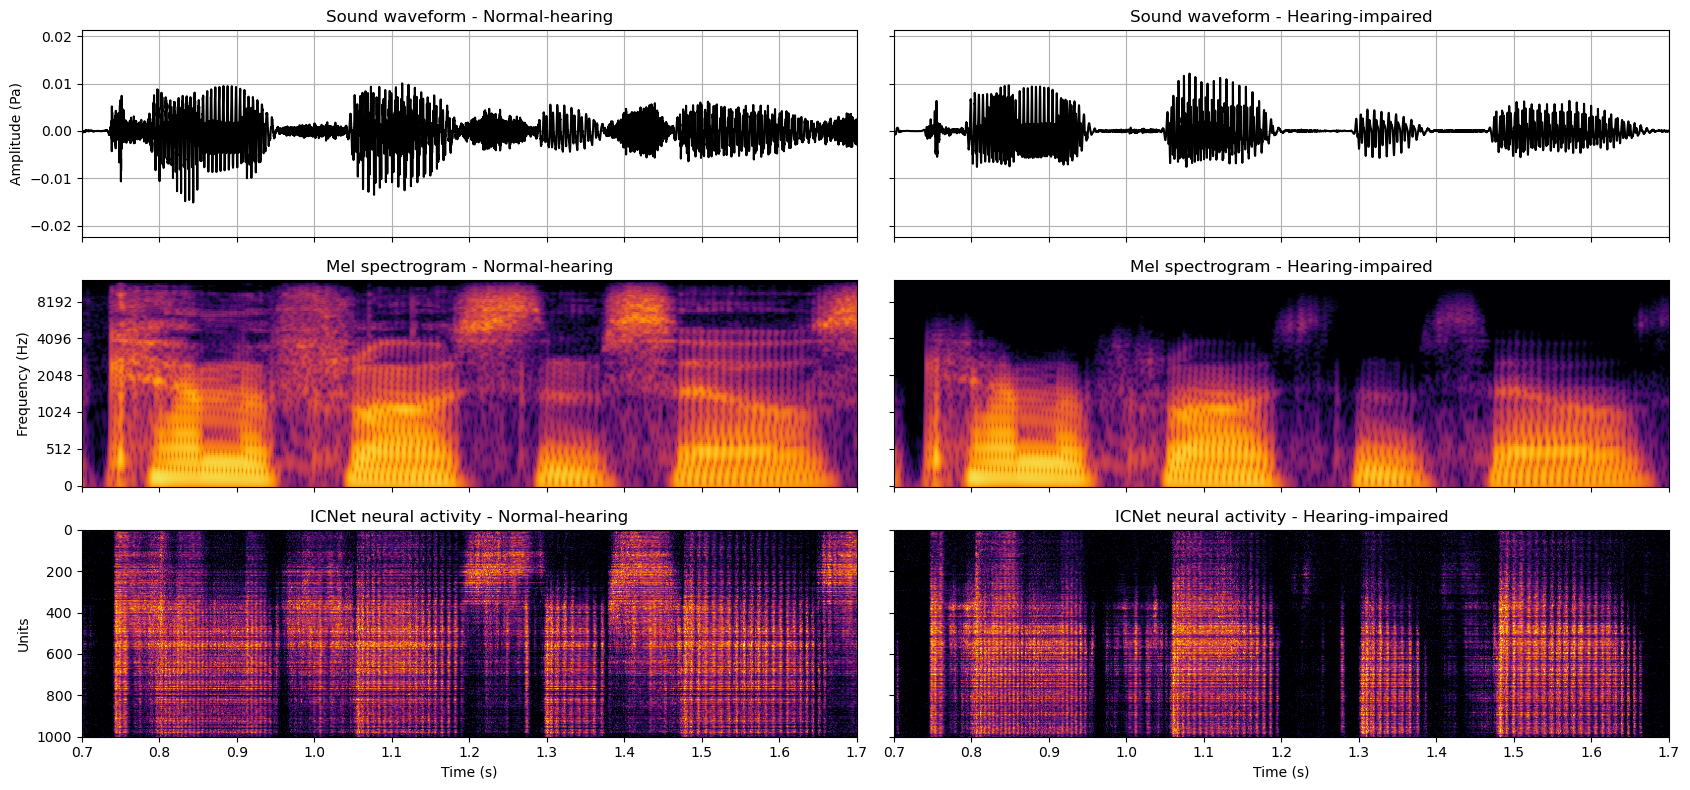

In [21]:
# Plot the audio inputs and neural outputs
f, ax = plt.subplots(3,2,figsize=(17,8), sharex=True, sharey='row')

# Sound waveform
ax[0,0].plot(t_audio,audio_nh,'k')
ax[0,1].plot(t_audio,audio_hl,'k')
ax[0,0].set_ylabel('Amplitude (Pa)')
ax[0,0].set_title('Sound waveform - Normal-hearing')
ax[0,1].set_title('Sound waveform - Hearing-impaired')
ax[0,0].grid();
ax[0,1].grid();

# Mel spectrogram
melspec = librosa.feature.melspectrogram(y=audio_nh, sr=fs_audio_icnet, n_fft=1024, hop_length=32, win_length=256, n_mels=128, fmin=50, fmax=12000)
melspec = librosa.power_to_db(melspec, ref = p0 ** 2, top_db = 100)
img = librosa.display.specshow(melspec, sr=fs_audio_icnet, hop_length=32, cmap='inferno', ax=ax[1,0], x_axis='time', y_axis='mel');
melspec = librosa.feature.melspectrogram(y=audio_hl, sr=fs_audio_icnet, n_fft=1024, hop_length=32, win_length=256, n_mels=128, fmin=50, fmax=12000)
melspec = librosa.power_to_db(melspec, ref = p0 ** 2, top_db = 100)
img = librosa.display.specshow(melspec, sr=fs_audio_icnet, hop_length=32, cmap='inferno', ax=ax[1,1], x_axis='time', y_axis='mel');
for i in range(2):
    ax[1,i].set_xlabel('')
    ax[1,i].set_ylabel('')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_title('Mel spectrogram - Normal-hearing')
ax[1,1].set_title('Mel spectrogram - Hearing-impaired')

# ICNet response
img = ax[2,0].imshow(ICNet_response_nh.T, aspect='auto', extent=[0,t_MUA[-1],output_channels,0], origin='lower', cmap='inferno', vmin=0, vmax=3)
img = ax[2,1].imshow(ICNet_response_hl.T, aspect='auto', extent=[0,t_MUA[-1],output_channels,0], origin='lower', cmap='inferno', vmin=0, vmax=3)
ax[2,0].set_ylabel('Units')
ax[2,0].set_title('ICNet neural activity - Normal-hearing')
ax[2,1].set_title('ICNet neural activity - Hearing-impaired')
for i in range(2):
    ax[2,i].set_xlabel('Time (s)')
    ax[2,i].xaxis.set_major_formatter(ScalarFormatter())
    if len(time_range):
        ax[2,i].set_xlim(time_range)

f.tight_layout();